In [1]:
# 驚きだが、chain数が1ならちゃんと動く
# https://jeremy9959.net/Blog/StanMixture/

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pystan
import pandas as pd
from scipy.special import expit as logistic
import arviz as az

np.set_printoptions(precision=2, suppress = True)

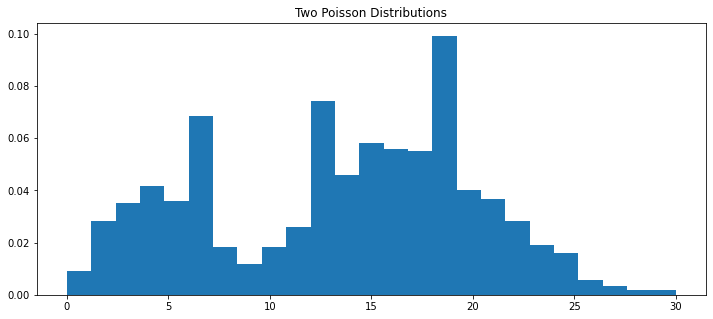

In [3]:
K = 2

A_lambda = 5
B_lambda = 17

A_num = 300
B_num = 700
total = A_num + B_num

A = np.random.poisson(A_lambda, A_num)
B = np.random.poisson(B_lambda, B_num)

X = np.concatenate([A, B])

plt.figure(figsize=(12, 5))
plt.title('Two Poisson Distributions')
plt.hist(X, bins = 25, density = True)
plt.show()

In [4]:
stan_data = {
    'N': total,
    'K': K,
    'X': X,
}

In [5]:
stan_code = """
data{
    int N;
    int K;
    int X[N];
}

parameters {
    real lambda[K];
    simplex[K] pi;
}

model {
    real lp[K];
    pi ~ beta(5, 5);
    
    for(n in 1:N){
        for (k in 1:K){
            lp[k] = log(pi[k]) + poisson_lpmf(X[n] | lambda[k]);
        }
        target += log_sum_exp(lp);
    }
}
"""

In [6]:
sm = pystan.StanModel(model_code= stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_53e9aa59f2c32ff25979e9257ba5e0e7 NOW.


In [7]:
mcmc_result = sm.sampling(
    data=stan_data,
    chains=1,
    iter=3000,
    warmup=2000,
    thin=1
)

In [8]:
print(mcmc_result)

Inference for Stan model: anon_model_53e9aa59f2c32ff25979e9257ba5e0e7.
1 chains, each with iter=3000; warmup=2000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda[1]  16.83  6.2e-3   0.17  16.51  16.72  16.83  16.95  17.17    726    1.0
lambda[2]   4.83  5.0e-3   0.15   4.51   4.73   4.83   4.93   5.14    974    1.0
pi[1]       0.71  4.9e-4   0.01   0.68    0.7   0.71   0.72   0.74    911    1.0
pi[2]       0.29  4.9e-4   0.01   0.26   0.28   0.29    0.3   0.32    911    1.0
lp__       -3180    0.05    1.2  -3183  -3181  -3180  -3179  -3179    539    1.0

Samples were drawn using NUTS at Wed Oct  6 21:08:03 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


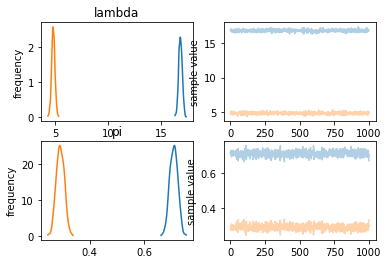

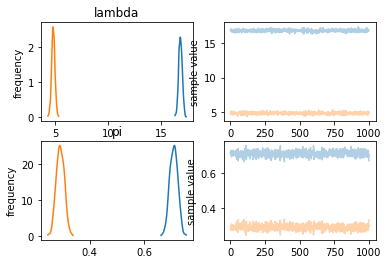

In [9]:
mcmc_result.plot()